In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

In [2]:
df = pd.read_csv("data/test_ABT.csv")
df.shape

(24510, 5)

In [3]:
df.tail(10)

,make,version,year,kms,price
24500,CITROEN C3,1.4 E-HDI 68CH EXCLUSIVE,2009,35000,6990
24501,CITROEN C3,PURETECH 82 CV CONFORT,2016,25000,9990
24502,PEUGEOT 3008,1.6 THP 180 GT-LINE T.O EAT8 -16%,2019,20,35480
24503,PEUGEOT 308,1.2 PURETECH 110 ALLURE -28%,2019,20,19480
24504,CITROEN C4,PICASSO 1.2 PURETECH 130 EAT6 SHINE,2017,37341,19990
24505,CITROEN C5,2.0 HDI 140 CV PACK AMBIANCE,2009,150000,5990
24506,PEUGEOT 308,308 1.6 HDI 120 CV STYLE S/S AVEC 150000 KLM D...,2017,150000,10000
24507,PEUGEOT 308,SW 120 CH GARANTI 12 MOIS 13890,2018,59000,13890
24508,PEUGEOT 208,PURETECH 110CH S BVM6 GT LINE,2019,10,17480
24509,PEUGEOT 308,PURETECH 110CH S BVM6 ACTIVE,2018,18120,17250


In [4]:
MAX_CV = 20 
MIN_CH = 50
MAX_CH = 500
MAX_ENGINE_SIZE = 5.0

power_re= re.compile('(\d+)\s?C[V, H]')
power_re_bis = re.compile('(\d\d+)(\s?\w?\w?\w?)')

#eng_size_re = re.compile('\s?(\d[\.,]\d)[\s, L, I]')
eng_size_re_float = re.compile('\d[\.,]\d')
eng_size_re_bis = re.compile('[^\d](\d)(\s?[a-zA-Z\-]+)')

def get_power(make, version):
    make_version = (make + " " + version).upper()
    power = re.findall(power_re, make_version)
    # si la puissance est inférieur à 20 on peut estimer qu'il s'agit de chevaux fiscaux et non chevaux vapeurs
    if power:
        max_power = max(int(e) for e in power) 
        if max_power > MAX_CV:
            return max_power
    # Si CH ou CV non trouvé on cherche un nombre dans "version" supérieur à 50 et inférieur à 500 (val approx min et max d'une puissance)
    power2 = re.findall(power_re_bis, version.upper())
    if power2:
        for match in power2:
            if 'KM' in match[1]:
                continue
            elif MIN_CH < int(match[0]) < MAX_CH:
                return int(match[0])   
    return None
    

def get_engine_size(make, version):
    make_version = (make + " " + version).upper()
    float_eng_size = re.findall(eng_size_re_float, make_version)
    if float_eng_size:
        float_list = []
        for float_size in float_eng_size:
            float_size = float(float_size.replace(",", "."))
            if 0.0 < float_size < MAX_ENGINE_SIZE:
                return float_size
    # in case we didn't find a float between 0 and MAX_ENGINE_SIZE let's see if this data is not in integer value eg 2L
    eng_size = re.findall(eng_size_re_bis, make_version)
    if eng_size:
        if len(eng_size)> 1:
            accepted_postfixe = ["L"]
            for match in eng_size:
                if match[1] in accepted_postfixe:
                    if 0.0 < float(match[0]) < 5.0:
                        return float(match[0])
            #print(make_version)
    return None
        
        
df["power"] = df.apply(lambda row:get_power(row["make"], row["version"]), axis=1)
df["eng_size"] = df.apply(lambda row: get_engine_size(row["make"], row["version"]), axis=1)

In [5]:
df.head()

,make,version,year,kms,price,power,eng_size
0,PEUGEOT 2008,2008 FELINE TITANE E-HDI 115 CV TETS OPTIONS,2015,97000,12990,115.0,NaN
1,CITROEN DS3,E-HDI 90 SO IRRESISTIBLE,2015,76174,10750,90.0,NaN
2,PEUGEOT 308,II (2) 1.2 PURETECH S&S 110 ALLURE,2018,9762,17890,110.0,1.2
3,CITROEN C4,CACTUS PURETECH 110CH S&S SHINE,2018,18527,18290,110.0,NaN
4,CITROEN C3,GENERATION-I 1.6 110 EXCLUSIVE BVA,2006,117000,4500,110.0,1.6


In [6]:
df.dtypes

make         object
version      object
year          int64
kms           int64
price         int64
power       float64
eng_size    float64
dtype: object

In [7]:
df.shape[0], df["eng_size"].isnull().sum(), df["power"].isnull().sum()

(24510, 8673, 62)

In [8]:
df[df["eng_size"].isnull()]

,make,version,year,kms,price,power,eng_size
0,PEUGEOT 2008,2008 FELINE TITANE E-HDI 115 CV TETS OPTIONS,2015,97000,12990,115.0,NaN
1,CITROEN DS3,E-HDI 90 SO IRRESISTIBLE,2015,76174,10750,90.0,NaN
3,CITROEN C4,CACTUS PURETECH 110CH S&S SHINE,2018,18527,18290,110.0,NaN
6,CITROEN C4,CITROEN GRAND C4 PICASSO PURETECH 130 S&S E...,2018,7820,22995,130.0,NaN
9,CITROEN C3,PICASSO PURETECH 110 EXCLUSIVE,2015,51946,10990,110.0,NaN
...,...,...,...,...,...,...,...
24498,CITROEN C3 AIRCROSS,PURETECH 110 EAT6 SHINE -18%,2019,20,21280,110.0,NaN
24501,CITROEN C3,PURETECH 82 CV CONFORT,2016,25000,9990,82.0,NaN
24507,PEUGEOT 308,SW 120 CH GARANTI 12 MOIS 13890,2018,59000,13890,120.0,NaN
24508,PEUGEOT 208,PURETECH 110CH S BVM6 GT LINE,2019,10,17480,110.0,NaN


# VIZUALISATION

In [9]:
df.make.value_counts()

CITROEN C4              3682
CITROEN C3              3255
PEUGEOT 308             2936
PEUGEOT 208             2583
PEUGEOT 3008            1949
PEUGEOT 2008            1757
CITROEN C3 AIRCROSS      831
CITROEN C5               760
PEUGEOT 207              699
PEUGEOT 508              595
PEUGEOT 5008             557
CITROEN BERLINGO         547
CITROEN DS3              471
CITROEN C1               427
CITROEN SPACETOURER      420
PEUGEOT 206              417
PEUGEOT 307              260
PEUGEOT AUTRES           260
CITROEN DS4              206
PEUGEOT 108              198
PEUGEOT 407              192
CITROEN XSARA            189
PEUGEOT PARTNER          179
CITROEN DS5              168
CITROEN C2               112
PEUGEOT 107               93
PEUGEOT RCZ               68
PEUGEOT TRAVELLER         62
CITROEN AUTRES            62
CITROEN C8                50
CITROEN JUMPY             46
CITROEN NEMO COMBI        41
PEUGEOT 607               39
PEUGEOT 1007              39
CITROEN JUMPER

In [10]:
def display_make(df, make):
    make_df = df[df["make"]==make]
    plt.figure(figsize=(7,7))
    sns.jointplot(x=make_df.kms.values, y=make_df.price.values, height=7)
    plt.ylabel('Price', fontsize=12)
    plt.xlabel('km', fontsize=12)
    plt.title("km Vs price", fontsize=12)
    sns.jointplot(x=make_df.year.values, y=make_df.price.values, height=7)
    plt.ylabel('Price', fontsize=12)
    plt.xlabel('year', fontsize=12)
    plt.title("year Vs price", fontsize=12)
    plt.show()

<Figure size 504x504 with 0 Axes>

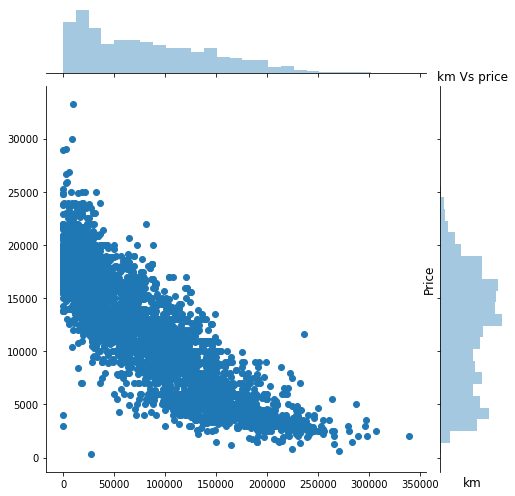

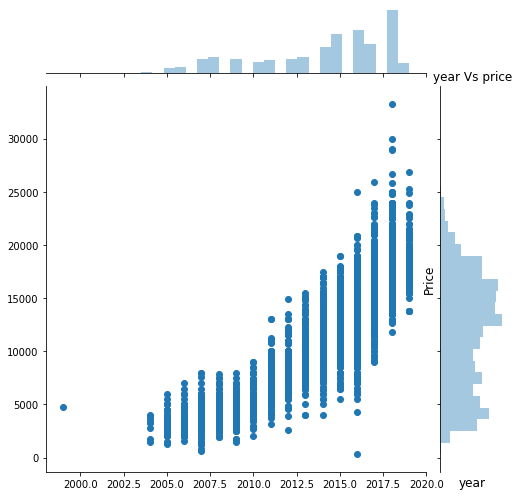

In [11]:
display_make(df, "CITROEN C4")

# Display removing outlier values

In [12]:
c4_df = df[df["make"]=="CITROEN C4"]

In [13]:
kms_ulimit = np.percentile(c4_df.kms.values, 99)
kms_llimit = np.percentile(c4_df.kms.values, 1)
kms_df = c4_df
kms_df['kms'].loc[kms_df['kms']>kms_ulimit] = kms_ulimit
kms_df['kms'].loc[kms_df['kms']<kms_llimit] = kms_llimit

/Users/antoine/Documents/Tests/interview/acuity/acuity_proj/venv/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/antoine/Documents/Tests/interview/acuity/acuity_proj/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/antoine/Documents/Tests/interview/acuity/acuity_proj/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See t

<Figure size 504x504 with 0 Axes>

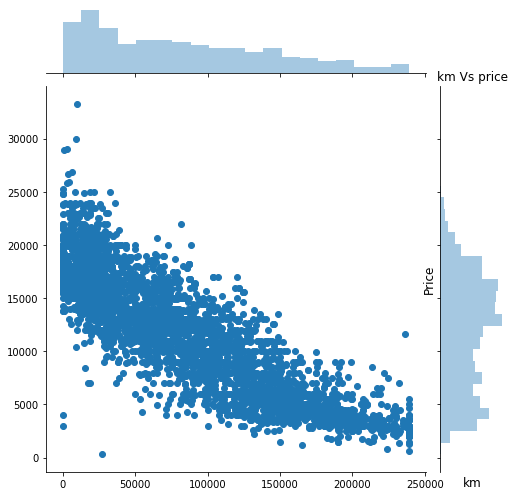

In [14]:
plt.figure(figsize=(7,7))
sns.jointplot(x=kms_df.kms.values, y=kms_df.price.values, height=7)
plt.ylabel('Price', fontsize=12)
plt.xlabel('km', fontsize=12)
plt.title("km Vs price", fontsize=12)
plt.show()

In [15]:
year_llimit = np.percentile(df.year.values, 1)
year_df = c4_df
year_df['year'].loc[year_df['year']<year_llimit] = year_llimit

/Users/antoine/Documents/Tests/interview/acuity/acuity_proj/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 504x504 with 0 Axes>

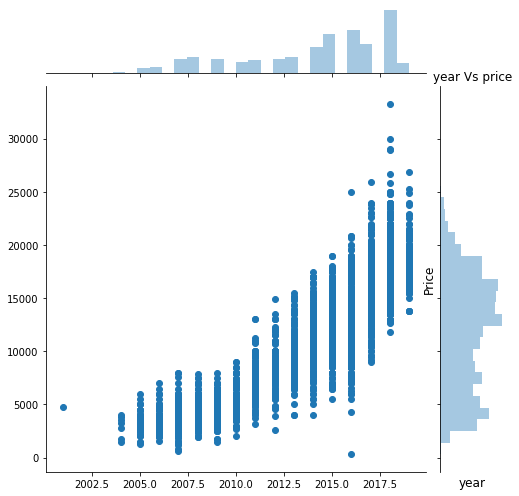

In [17]:
plt.figure(figsize=(7,7))
sns.jointplot(x=year_df.year.values, y=year_df.price.values, height=7)
plt.ylabel('Price', fontsize=12)
plt.xlabel('year', fontsize=12)
plt.title("year Vs price", fontsize=12)
plt.show()

#  3D plot

In [103]:
from mpl_toolkits.mplot3d import Axes3D

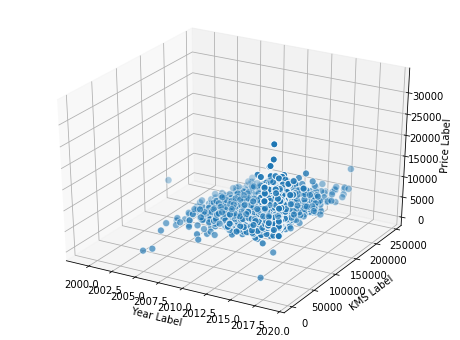

In [104]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c4_df.year.values, c4_df.kms.values, c4_df.price.values, s=50, edgecolors='w')
ax.set_xlabel('Year Label')
ax.set_ylabel('KMS Label')
ax.set_zlabel('Price Label')

plt.show()

#  Scatter matrix 

<Figure size 1080x1080 with 0 Axes>

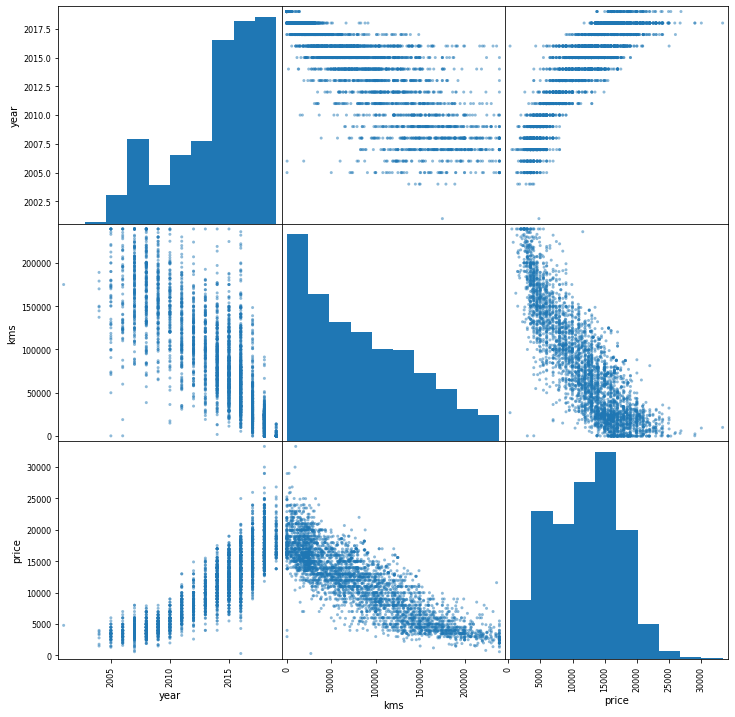

In [18]:
from pandas.plotting import scatter_matrix
fig = plt.figure(figsize=(15, 15))
scatter_matrix(c4_df[["year","kms", "price"]],figsize=(12, 12))
plt.show()